In [ ]:
#NOTE NEED TO RESAMPLE FROM 10K TO 32K BEFORE RUNNING THE ANALYSIS
'''
wb_command -label-resample \
  L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.10k_fs_LR.label.gii \
  spheres/MacaqueYerkes19.L.sphere.10k_fs_LR.surf.gii \
  spheres/MacaqueYerkes19.L.sphere.32k_fs_LR.surf.gii \
  ADAP_BARY_AREA \
  L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.32k_fs_LR.label.gii \
  -area-surfs \
  surfaces/MacaqueYerkes19.L.midthickness.10k_fs_LR.surf.gii \
  surfaces/MacaqueYerkes19.L.midthickness.32k_fs_LR.surf.gii \
  -largest
'''


In [ ]:
# --- Imports ---
import os
import sys
import io
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyvista as pv
import yaspy

# --- Paths ---
# Notebook and utils
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '../092325_cortical_gradients')))
from gradient_utils import *

# Data paths
base_path = '/Users/dennis.jungchildmind.org/Desktop/thomas-macaquedat/'

surface_template_path = (
    '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/'
    'parcellation/macaque/MacaqueYerkes19_v1.2_Vj_976nz/MNINonLinear/fsaverage_LR32k/'
    'MacaqueYerkes19_v1.2.L.midthickness.32k_fs_LR.surf.gii'
)
atlas_lh_path = (
    '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/'
    'parcellation/macaque/L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.32k_fs_LR.label.gii'
)
total_path = os.path.join(base_path, 'macaque_cortical_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii')
supra_path = os.path.join(base_path, 'macaque_infragranular_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii')
infra_path = os.path.join(base_path, 'macaque_supragranular_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii')

# --- Data Loading ---
atlas_lh = nib.load(atlas_lh_path).darrays[0].data

total_thickness = nib.load(total_path).darrays[0].data
supra_thickness = nib.load(supra_path).darrays[0].data
infra_thickness = nib.load(infra_path).darrays[0].data

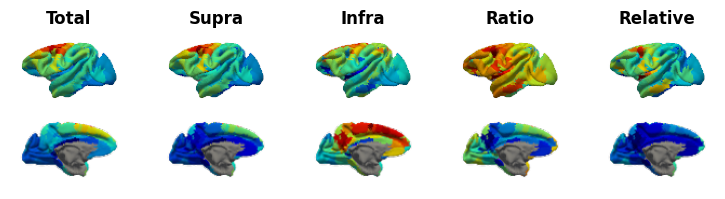

In [3]:
# ====== CONFIG ======
LAYER_TYPES = ['total', 'supra', 'infra', 'ratio', 'relative']
thickness_types = [
    ('total', total_thickness),
    ('supra', supra_thickness),
    ('infra', infra_thickness)
]
lh_surf = surface_template_path  # Path to the surface template


# ====== FUNCTIONS ======

def mapping_to_atlas(data_parc, atlas_data):
    """
    Map parcellated data to atlas-space using atlas labels.
    """
    mapped_values = np.full(len(atlas_data), np.nan)
    mask = atlas_data != 0
    mapped_values[mask] = data_parc[atlas_data[mask] - 1]
    return mapped_values


def process_hemisphere(data_parc, atlas_data, surf_path, hemi, vmin=None, vmax=None, cmap='jet'):
    """
    Map data to atlas and generate yaspy plots, returning screenshot images and overlay.
    """
    means = np.nanmean(data_parc, axis=1) if data_parc.ndim != 1 else data_parc
    mean_surfaces = mapping_to_atlas(means, atlas_data)

    vmin_mean = np.round(np.nanmin(mean_surfaces), 2) if vmin is None else vmin
    vmax_mean = np.round(np.nanmax(mean_surfaces), 2) if vmax is None else vmax

    plotter_mean = yaspy.Plotter(surf_path, hemi=hemi)
    overlay_mean = plotter_mean.overlay(mean_surfaces, cmap=cmap, alpha=1, vmin=vmin_mean, vmax=vmax_mean)
    plotter_mean.border(mean_surfaces, alpha=0)
    screenshots = [plotter_mean.screenshot(view) for view in ("lateral", "medial")]

    return [[*screenshots, overlay_mean]], vmin_mean, vmax_mean


def create_montage(plotters):
    """
    Assemble lateral and medial view screenshots into yaspy montage.
    """
    lateral_row = [p[0] for p in plotters]
    medial_row = [p[1] for p in plotters]
    return yaspy.montage([lateral_row, medial_row], pad=10, shareh=True, sharew=True)


def add_colorbar(ax, vmin, vmax, cmap):
    """
    Add a horizontal colorbar beneath the axis.
    """
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(sm, cax=cax, orientation="horizontal")


def plot_montage_with_colorbar(montage_img, vmin, vmax, cmap, title=None):
    """
    Display montage image and colorbar, return matplotlib axes.
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(montage_img)
    ax.axis('off')
    add_colorbar(ax, vmin, vmax, cmap)
    if title is not None:
        ax.set_title(title, fontsize=16, fontweight='bold')
    fig.tight_layout()
    # plt.show() NOT called here
    return fig, ax


# ====== DATA PROCESSING ======

def prepare_lh_parc_data(thickness_types, atlas_lh):
    """
    Parcellate and mask data, then compute ratio metrics.
    """
    lh_parc_data = {}
    # Parcellate and mask
    for name, thickness in thickness_types:
        parc = parcellate_data(thickness, atlas_lh)
        parc = parc.astype(float)   # ensure np.nan works
        parc[parc == 0] = np.nan
        lh_parc_data[name] = parc

    # Calculate ratio metrics
    lh_parc_data['ratio'] = lh_parc_data['supra'] / lh_parc_data['total']
    lh_parc_data['relative'] = lh_parc_data['supra'] / lh_parc_data['infra']
    return lh_parc_data


def generate_figures_for_layers(layer_types, lh_parc_data, atlas_lh, lh_surf):
    """
    Process and create montage/colorbar figures for each layer_type.
    """
    axes_list = []
    titles = []

    for layer_type in layer_types:
        # Process and plot only LH
        plotters_lh_mean, vmin_lh, vmax_lh = process_hemisphere(lh_parc_data[layer_type], atlas_lh, lh_surf, 'lh')
        montage_img = create_montage(plotters_lh_mean)
        # Get colormap from the overlay object
        cmap = plotters_lh_mean[0][2].get_cmap()
        fig, ax = plot_montage_with_colorbar(montage_img, vmin_lh, vmax_lh, cmap, title=layer_type.capitalize())
        axes_list.append((fig, ax))
        titles.append(layer_type.capitalize())
        plt.close(fig)  # Close individual figures to avoid duplicate display

    return axes_list, titles


def plot_combined_row(axes_list, titles):
    """
    Plot all axes' contents into a single large row.
    """
    n_layers = len(axes_list)
    fig_row, axs = plt.subplots(1, n_layers, figsize=(n_layers*1.5, 2))

    if n_layers == 1:
        axs = [axs]

    for i, (fig, ax) in enumerate(axes_list):
        # Copy the image from imshow in each ax to the new axs[i]
        for im in ax.get_images():
            axs[i].imshow(im.get_array())
        axs[i].set_axis_off()
        axs[i].set_title(titles[i], fontsize=12, fontweight='bold')
        # Colorbar transfer is omitted for the row montage

    fig_row.tight_layout()
    plt.show()


def save_parc_data(base_path, lh_parc_data, layer_types):
    """
    Save the parcellated data in npz format.
    """
    dat_save_path = os.path.join(base_path, 'data')
    os.makedirs(dat_save_path, exist_ok=True)
    np.savez(
        os.path.join(dat_save_path, 'lh_parc_macaque_schaefer400.npz'),
        **{k: lh_parc_data[k] for k in layer_types}
    )


# ====== MAIN EXECUTION ======

if __name__ == "__main__" or True:  # So that this runs in a notebook cell.
    # Prepare data
    lh_parc_data = prepare_lh_parc_data(thickness_types, atlas_lh)

    # Generate figures for each cortical layer
    axes_list, titles = generate_figures_for_layers(LAYER_TYPES, lh_parc_data, atlas_lh, lh_surf)

    # Plot combined montage row
    plot_combined_row(axes_list, titles)

    # Save the data arrays
    save_parc_data(base_path, lh_parc_data, LAYER_TYPES)
